<font size = "5"> **EELS_Tools:  [Spectroscopy](../4_EELS_Tools.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />

# Analysis of EDS Spectra
<br>

[<img src=https://www.coeuscreativegroup.com/wp-content/uploads/2020/04/download-button.png, width=125>](https://raw.githubusercontent.com/pycroscopy/pyTEMlib/main/notebooks/Spectroscopy/EDS.ipynb) 

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/pycroscopy/pyTEMlib/blob/main/notebooks/Spectroscopy/EDS.ipynb)
    
part of 

<font size = "5"> **[pyTEMlib](https://pycroscopy.github.io/pyTEMlib/about.html)**</font>

a [pycroscopy](https://pycroscopy.github.io/pycroscopy/about.html) ecosystem package



Notebook by Gerd Duscher, 2025

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes

## Content
An Introduction into displaying and analyzing EDS spectrum images and spectra
This works also on Google Colab.


## Prerequesites

### Install pyTEMlib

If you have not done so in the [Introduction Notebook](_.ipynb), please test and install [pyTEMlib](https://github.com/gduscher/pyTEMlib) and other important packages with the code cell below.


In [2]:
import sys
import importlib.metadata

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version


# pyTEMlib setup ------------------
if test_package('pyTEMlib') < '0.2024.02.0':
    print('installing pyTEMlib')
   
    !{sys.executable} -m pip install pyTEMlib -q --upgrade

# ------------------------------
print('done')

done


### Loading of necessary libraries

Please note, that we only need to load the pyTEMlib library, which is based on sidpy Datsets.



In [1]:
%matplotlib widget
import numpy as np
import scipy

import matplotlib.pylab as plt
import sys

if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()
    from google.colab import drive

import pyTEMlib

    # using  pyTEMlib.eds_tools, pyTEMlib.file_tools and pyTEMlib.eels_tools (for line definitions)
if 'google.colab' in sys.modules:
    drive.mount("/content/drive")

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)
__notebook__ = 'EDS_Spectrum_Analysis'
__notebook_version__ = '2025_09_23'

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
Using kinematic_scattering library version 0.2022.1.0  by G.Duscher
pyTEM version:  0.2025.09.2


## Open File

### Load File

Select a main dataset and any additional data like reference data and such.

In [3]:
fileWidget = pyTEMlib.file_tools.FileWidget()


### Select and Plot Dataset

Select a dataset from the drop down value and display it with the code cell below.

Here we sum the spectra of the 4 quadrants and define the detector parameter.

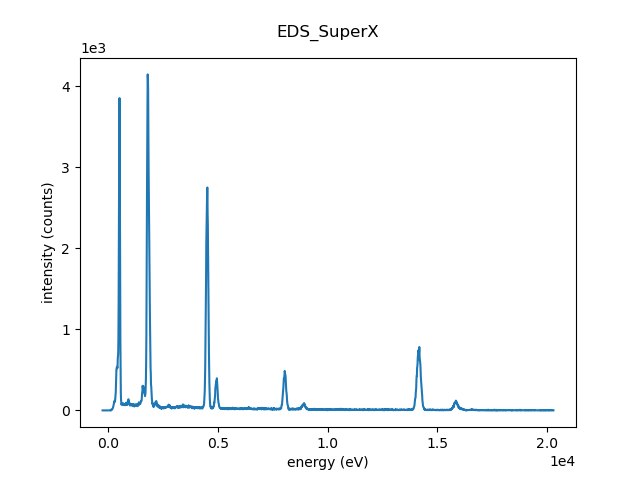

In [4]:
spectrum = fileWidget.selected_dataset
import pyTEMlib.eds_xsections
start = np.searchsorted(spectrum.energy_scale.values, 100)
energy_scale = spectrum.energy_scale.values[start:]
detector_Efficiency= pyTEMlib.eds_tools.detector_response(spectrum)  # tags, spectrum.energy_scale.values[start:])
if 'start_energy' not in spectrum.metadata['EDS']['detector']:
    spectrum.metadata['EDS']['detector']['start_energy'] = 120
spectrum[:np.searchsorted(spectrum.energy_scale.values,spectrum.metadata['EDS']['detector']['start_energy'])] = 0.
spectrum.metadata['EDS']['detector']['detector_efficiency']  = detector_Efficiency
view = spectrum.plot()

## Find Elements 

C:\Users\gduscher\AppData\Local\anaconda3\Lib\site-packages\dask\array\core.py:1744: FutureWarning: The `numpy.argsort` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


['Ti', 'Cu', 'Sr', 'O']


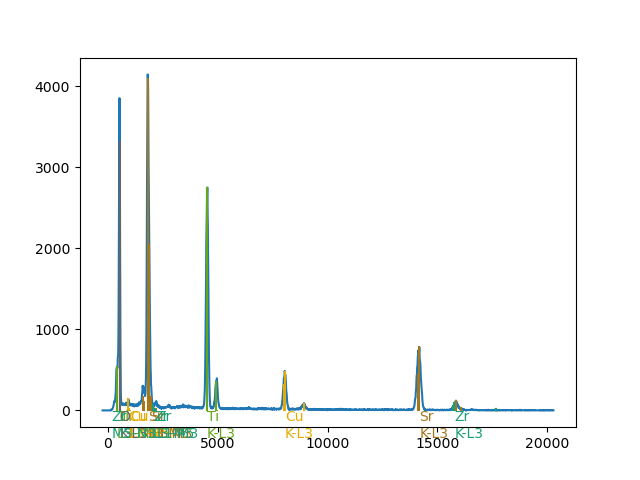

In [9]:
# --------Input -----------
minimum_number_of_peaks = 10
# --------------------------
minor_peaks = pyTEMlib.eds_tools.detect_peaks(spectrum, minimum_number_of_peaks=minimum_number_of_peaks)

keys = list(spectrum.metadata['EDS'].keys())
for key in keys:
    if len(key) < 3:
        del spectrum.metadata['EDS'][key]

elements = pyTEMlib.eds_tools.find_elements(spectrum, minor_peaks)

print(elements) 
elements += ['Zr']
spectrum.metadata['EDS'].update(pyTEMlib.eds_tools.get_x_ray_lines(spectrum, elements))
plt.figure()
plt.plot(spectrum.energy_scale,spectrum, label = 'spectrum')
pyTEMlib.eds_tools.plot_lines(spectrum.metadata['EDS'], plt.gca())


## Quantify

### Fit spectrum

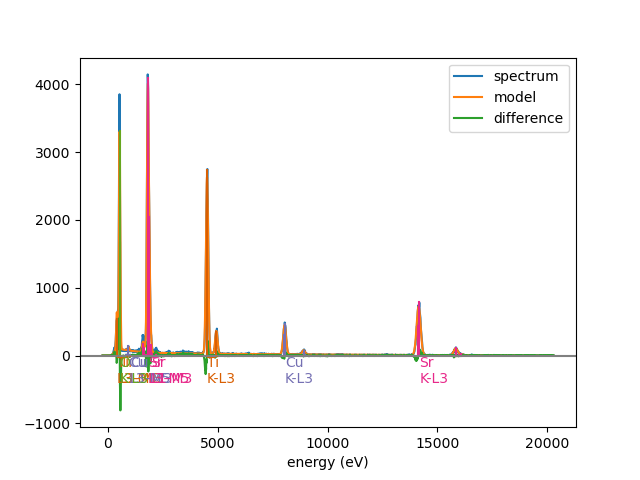

In [6]:
peaks, pp = pyTEMlib.eds_tools.fit_model(spectrum, use_detector_efficiency=True)
model = pyTEMlib.eds_tools.get_model(spectrum)

plt.figure()
plt.plot(spectrum.energy_scale, spectrum, label='spectrum')
plt.plot(spectrum.energy_scale, model, label='model')
plt.plot(spectrum.energy_scale, spectrum-model, label='difference')
plt.xlabel('energy (eV)')
pyTEMlib.eds_tools.plot_lines(spectrum.metadata['EDS'], plt.gca())
plt.axhline(y=0, xmin=0, xmax=1, color='gray')
plt.legend()

### Quantify Spectrum
first with Bote-Salvat cross section

In [7]:
pyTEMlib.eds_tools.quantify_EDS(spectrum, mask =['Cu'])

using cross sections for quantification
Ti: 17.91 at% 26.07 wt%
Sr: 15.60 at% 41.57 wt%
O : 66.49 at% 32.36 wt%


In [8]:
q_dict = pyTEMlib.eds_tools.load_k_factors()
tags = pyTEMlib.eds_tools.quantify_EDS(spectrum, q_dict, mask = ['Cu'])

using k-factors for quantification
Ti: 22.51 at% 27.74 wt%
Sr: 21.87 at% 49.34 wt%
O : 55.62 at% 22.91 wt%
excluded from quantification  ['Cu']


## Summary
The spectrum is modeled completely with background and characteristic peak-families.

Either 
- k-factors in a file (here from Spectra300) or
- Bothe-Salvat cross-sections
 
are used for quantification.

## Appendix
### Background
The determined background used for the model-based quantification is based on the detector effciency.

Note:

The detector efficiency is also used for the quantification model.
